### Training Deep Networks from Zero to Hero: avoiding pitfalls and going beyond
#### A Tutorial presented at SIBGRAPI 2021

**Moacir Antonelli Ponti**, Fernando Pereira dos Santos, Leo Sampaio Ferraz Ribeiro, Gabriel Biscaro Cavallari

Paper (extended version): https://arxiv.org/abs/2109.02752

## Part 1 - How to Start

### Notebook 3 - **Options for small datasets**
---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy.random import seed
from tensorflow.random import set_seed

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

# selecting only 50% for training
(train_ds, validation_ds, test_ds), info = tfds.load(
    "beans",
    split=["train[0%:50%]", "validation[0%:100%]", "test[0%:100%]"],
    as_supervised=True, 
    with_info=True
)

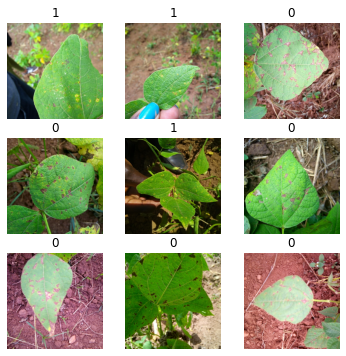

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")


In [ ]:
print(info)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

# redimensionando exemplos e normalizando entre 0-1 tipo float32
img_size = (128, 128)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), tf.one_hot(y,3)))
train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, img_size), tf.one_hot(y,3)))
validation_ds = validation_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, img_size), tf.one_hot(y,3)))
test_ds = test_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

input_shape = img_size+(3,)

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://git

In [ ]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

---

### Data Augmentation: 

Works as a preprocessing layer that will randomly activate specific perturbations in the data

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomFlip("vertical"),
        layers.experimental.preprocessing.RandomRotation(0.25),
        layers.experimental.preprocessing.RandomContrast(0.3),
    ]
)

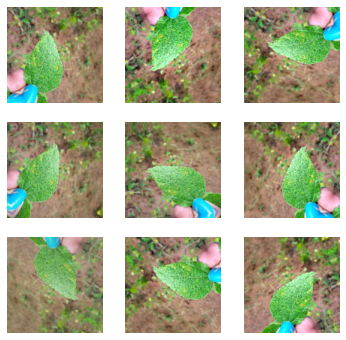

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(6, 6))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(images[1], 0), training=True
        )
        #plt.title(str(labels[i].numpy()))
        plt.imshow(augmented_image[0].numpy())
        plt.axis("off")


--- 
### 1 - Trying to train a network from scratch

Since we have a small dataset, we will load a MobileNetV2 architecture

The smaller CNN present in Keras

We use `include_top=False` to not include the classification layer


In [ ]:
base_model_random = tf.keras.applications.MobileNetV2(
    weights=None, # random weights
    input_shape=(128, 128, 3),
    include_top=False
)

# Allow the model to be trained
base_model_random.trainable = True

# Input layer
inputs = keras.Input(shape=(128, 128, 3))
# data augmentation layer
x = data_augmentation(inputs)
# base model
x = base_model_random(x, training=True)
# global average pooling
x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = keras.layers.Dropout(0.3)(x)
# classification layer
outputs = keras.layers.Dense(3, activation="softmax")(x)
model_random = keras.Model(inputs, outputs)

model_random.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
______________________________________________

In [ ]:
seed(1)
set_seed(2)

model_random.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss="categorical_crossentropy",
    metrics=["acc"],
)

epochs = 20
rand_hist = model_random.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
17/17 [==============================] - 40s 255ms/step - loss: 1.1638 - acc: 0.3540 - val_loss: 1.1115 - val_acc: 0.3383
Epoch 2/20
17/17 [==============================] - 2s 134ms/step - loss: 1.1176 - acc: 0.3907 - val_loss: 1.0983 - val_acc: 0.3609
Epoch 3/20
17/17 [==============================] - 2s 129ms/step - loss: 1.1473 - acc: 0.3714 - val_loss: 1.1072 - val_acc: 0.3759
Epoch 4/20
17/17 [==============================] - 2s 129ms/step - loss: 1.1450 - acc: 0.3462 - val_loss: 1.0934 - val_acc: 0.4135
Epoch 5/20
17/17 [==============================] - 2s 130ms/step - loss: 1.1279 - acc: 0.4023 - val_loss: 1.0929 - val_acc: 0.3759
Epoch 6/20
17/17 [==============================] - 2s 130ms/step - loss: 1.1424 - acc: 0.3733 - val_loss: 1.0849 - val_acc: 0.4060
Epoch 7/20
17/17 [==============================] - 2s 129ms/step - loss: 1.1135 - acc: 0.4120 - val_loss: 1.1066 - val_acc: 0.3759
Epoch 8/20
17/17 [==============================] - 2s 129ms/step - loss: 1

In [ ]:
scores = model_random.evaluate(validation_ds)
print('1 - Training from scratch. Scores: ', scores)

5/5 [==============================] - 0s 28ms/step - loss: 1.0538 - acc: 0.4361
1 - Training from scratch. Scores:  [1.0537880659103394, 0.43609023094177246]


--- 
### 2 - Loading pre-trained weights

Transfer learning from ImageNet pretrained model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(128, 128, 3),
    include_top=False
)

# Since the weights are pre-trained let us freeze them
base_model.trainable = False

inputs = keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs) 
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
# We are going to train only the last two layers
## dense/projection layer with 160
x = keras.layers.Dense(160,activation="relu", name="projection")(x)
x = keras.layers.Dropout(0.3)(x)
## classification layer
outputs = keras.layers.Dense(3,activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
projection (Dense)           (None, 160)               204960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
______________________________________________________________

In [ ]:
seed(1)
set_seed(2)

model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss="categorical_crossentropy",
    metrics=["acc"],
)

epochs = 16
pt_hist1 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/16
17/17 [==============================] - 5s 107ms/step - loss: 1.1713 - acc: 0.4449 - val_loss: 0.8548 - val_acc: 0.5789
Epoch 2/16
17/17 [==============================] - 1s 46ms/step - loss: 0.9344 - acc: 0.5841 - val_loss: 0.6590 - val_acc: 0.7594
Epoch 3/16
17/17 [==============================] - 1s 47ms/step - loss: 0.7947 - acc: 0.6499 - val_loss: 0.6254 - val_acc: 0.7293
Epoch 4/16
17/17 [==============================] - 1s 46ms/step - loss: 0.6899 - acc: 0.7002 - val_loss: 0.5546 - val_acc: 0.7669
Epoch 5/16
17/17 [==============================] - 1s 47ms/step - loss: 0.6624 - acc: 0.7292 - val_loss: 0.5253 - val_acc: 0.7895
Epoch 6/16
17/17 [==============================] - 1s 46ms/step - loss: 0.5955 - acc: 0.7524 - val_loss: 0.4973 - val_acc: 0.7669
Epoch 7/16
17/17 [==============================] - 1s 46ms/step - loss: 0.5642 - acc: 0.7350 - val_loss: 0.5060 - val_acc: 0.7669
Epoch 8/16
17/17 [==============================] - 1s 46ms/step - loss: 0.5294 - 

In [ ]:
scores = model.evaluate(validation_ds)
print('2 - Transfer Learning. Scores: ', scores)

5/5 [==============================] - 0s 27ms/step - loss: 0.4511 - acc: 0.7895
2 - Transfer Learning. Scores:  [0.4511469602584839, 0.7894737124443054]


## 3 - Fine-tuning of the weights

We train for a few more steps un-freezing some of the layers

In [ ]:
# unfreeze all model
base_model.trainable = True

# freeze again the first layers, only letting the last 4 to be adapted
for layer in base_model.layers[:-4]: 
    layer.trainable = False
    # make sure to also freeze BN layers
    if isinstance(layer, keras.layers.BatchNormalization):
        layer._per_input_updates = {}
        
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
projection (Dense)           (None, 160)               204960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 483 

In [ ]:
# make the learning rate even smaller!
model.compile(
    optimizer=keras.optimizers.Adam(10e-7), 
    loss="categorical_crossentropy",
    metrics=["acc"],
)
# only 5 epochs
epochs = 5
pt_hist2 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/5
17/17 [==============================] - 5s 104ms/step - loss: 0.3875 - acc: 0.8472 - val_loss: 0.4493 - val_acc: 0.7970
Epoch 2/5
17/17 [==============================] - 1s 47ms/step - loss: 0.4589 - acc: 0.8240 - val_loss: 0.4461 - val_acc: 0.7970
Epoch 3/5
17/17 [==============================] - 1s 47ms/step - loss: 0.3858 - acc: 0.8511 - val_loss: 0.4440 - val_acc: 0.7970
Epoch 4/5
17/17 [==============================] - 1s 47ms/step - loss: 0.3876 - acc: 0.8433 - val_loss: 0.4421 - val_acc: 0.7970
Epoch 5/5
17/17 [==============================] - 1s 48ms/step - loss: 0.4116 - acc: 0.8337 - val_loss: 0.4412 - val_acc: 0.7970


In [ ]:
scores = model.evaluate(validation_ds)
print('3 - Fine Tuning. Scores: ', scores)

5/5 [==============================] - 0s 27ms/step - loss: 0.4412 - acc: 0.7970
3 - Fine Tuning. Scores:  [0.44122767448425293, 0.7969924807548523]


Comparando o histórico das duas abordagens

Text(0.5, 1.0, 'Accuracy')

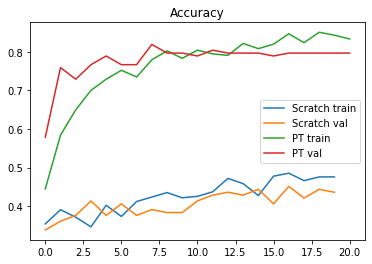

In [ ]:
pt_tra_hist = np.concatenate((pt_hist1.history['acc'], pt_hist2.history['acc']), axis=None)
pt_val_hist = np.concatenate((pt_hist1.history['val_acc'], pt_hist2.history['val_acc']), axis=None)

plt.plot(rand_hist.history['acc'])
plt.plot(rand_hist.history['val_acc'])
plt.plot(pt_tra_hist)
plt.plot(pt_val_hist)
plt.legend(['Scratch train','Scratch val','PT train','PT val'])
plt.title('Accuracy')

--- 
### 4 - Feature extraction: no training involved

Create a new non-trainable layer to obtain features after the last layer

In [ ]:
base_model_extraction = keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(128, 128, 3),
    include_top=False
)

# get the last layer output
base_output = base_model_extraction.layers[-1].output

# define Global Pooling layer to avoid high dimensionality
feat_layer = keras.layers.GlobalAveragePooling2D()(base_output)

# setup a new model
model_imagenet = keras.models.Model(base_model_extraction.inputs, feat_layer)

# obtaining features as "prediction"/output of the model
features_train_mobilenet = np.array(model_imagenet.predict(train_ds))
features_val_mobilenet = np.array(model_imagenet.predict(validation_ds))
features_test_mobilenet = np.array(model_imagenet.predict(test_ds))

print('\tTraining set size: ', features_train_mobilenet.shape)

	Training set size:  (517, 1280)


Now we can use those features as we please!

Let us analyzie it using PCA and afterwards train a shallow classifier

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(features_train_mobilenet)
pca_train_imagenet = pca.transform(features_train_mobilenet)

In [ ]:
print('Retained variance in 2 PCs')
print(pca.explained_variance_)

Retained variance in 2 PCs
[45.509846 36.83624 ]


In [ ]:
# get the training labels
train_ds2 = train_ds.map(lambda x, y: (x, tf.math.argmax(y,axis=1)))
train_labels = list(np.concatenate([y for x, y in train_ds2], axis=0))

# get validation labels
validation_ds2 = validation_ds.map(lambda x, y: (x, tf.math.argmax(y,axis=1)))
val_labels = list(np.concatenate([y for x, y in validation_ds2], axis=0))

# get test labels
test_ds2 = test_ds.map(lambda x, y: (x, tf.math.argmax(y,axis=1)))
test_labels = list(np.concatenate([y for x, y in test_ds2], axis=0))

In [ ]:
pca_train_imagenet.shape

(517, 2)

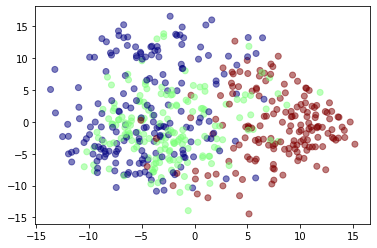

In [ ]:
colors = ((np.array(train_labels)/2)*100).astype(int)
plt.scatter(pca_train_imagenet[:,0], pca_train_imagenet[:,1], c=colors, alpha=0.5, cmap='jet')

Use features to train an SVM classifier

In [ ]:
from sklearn.svm import SVC

svm_feat1 = SVC(C=10, probability=True)
svm_feat1.fit(features_train_mobilenet, train_labels)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
print('4 - SVM Validation Accuracy:')
print(svm_feat1.score(features_val_mobilenet, val_labels))

4 - SVM Validation Accuracy:
0.8872180451127819


---
Final coparison

1. Training deep net from random weights (from scratch)
2. Loading pretrained weights + Transfer Learning + Fine-tuning
3. Feature extraction + SVM classifier

In [ ]:
scoresR = model_random.evaluate(test_ds, verbose=0)
scoresTL = model.evaluate(test_ds, verbose=0)
scoresF = svm_feat1.score(features_test_mobilenet, test_labels)

print('MobileNet trained from scratch: ', scoresR[1]*100)
print('MobileNet pre-trained transfer learning + fine-tuning: ', scoresTL[1]*100)
print('MobileNet features + SVM classifier: ', scoresF*100)

MobileNet trained from scratch:  47.65625
MobileNet pre-trained transfer learning + fine-tuning:  78.125
MobileNet features + SVM classifier:  91.40625
